# Imports

In [30]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer


from nltk.corpus import wordnet


#from gensim import corpora
#from gensim.models import LdaModel

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from textblob import TextBlob

# Download required nltk packages once
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# WEB SCRAPPING

In [31]:
# Initialize a list to store the reviews
reviews = []

# Base URL of the airline review page
base_url = "https://www.airlinequality.com/airline-reviews/british-airways/"

# Number of pages to scrape
num_pages = 2  # You can increase this as needed

for i in range(1, num_pages + 1):
    print(f"Scraping page {i}")

    # Construct the URL for each page
    url = f'{base_url}page/{i}/'

    # Send a GET request to the page
    response = requests.get(url)

    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all review elements (check the class name in the HTML)
    review_elements = soup.find_all('div', class_='body')

    # Extract text from each review element
    for review in review_elements:
        text = review.get_text(strip=True)
        reviews.append(text)

    # delay to avoid overloading the server
    time.sleep(1)

# Convert to DataFrame
df_reviews = pd.DataFrame(reviews, columns=['Review'])

# Optionally save to CSV
output_dir = './data'
os.makedirs(output_dir, exist_ok=True)
df_reviews.to_csv(f'{output_dir}/reviews.csv', index=False)

print(f"Scraping completed. {len(reviews)} reviews saved.")

print(df_reviews.head(5))


Scraping page 1
Scraping page 2
Scraping completed. 20 reviews saved.
                                              Review
0  "I was very disappointed"Kay Green(United King...
1  “great service from the crew”Richard Lark(Aust...
2  "Mumbai check in is not helpful"6 reviewsS Gap...
3  "arrived 20 min ahead of schedule"Michael Scha...
4  "crowded buses to take us to plane"T Barsova(U...


# Text Cleaning & Preprocessing

In [32]:
# Define function to clean text, remove unwanted characters, etc.
def clean(text):
    # Removes all special characters and numbers, keeps alphabets only
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

# Apply cleaning to scraped reviews
df_reviews['Cleaned_Reviews'] = df_reviews['Review'].apply(clean)

# Preview cleaned reviews
print(df_reviews[['Review', 'Cleaned_Reviews']].head())

                                              Review  \
0  "I was very disappointed"Kay Green(United King...   
1  “great service from the crew”Richard Lark(Aust...   
2  "Mumbai check in is not helpful"6 reviewsS Gap...   
3  "arrived 20 min ahead of schedule"Michael Scha...   
4  "crowded buses to take us to plane"T Barsova(U...   

                                     Cleaned_Reviews  
0   I was very disappointed Kay Green United King...  
1   great service from the crew Richard Lark Aust...  
2   Mumbai check in is not helpful reviewsS Gapat...  
3   arrived min ahead of schedule Michael Schade ...  
4   crowded buses to take us to plane T Barsova U...  


# POS Tagging & Lemmatization


In [33]:
pos_map = {'J': wordnet.ADJ,
           'V': wordnet.VERB,
           'N': wordnet.NOUN,
           'R': wordnet.ADV}

def get_wordnet_pos(treebank_tag):
    return pos_map.get(treebank_tag[0], wordnet.NOUN)

def pos_tag_text(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    tagged_wordnet = [(word, get_wordnet_pos(pos)) for word, pos in tagged]
    return tagged_wordnet

df_reviews['POS_tagged'] = df_reviews['Cleaned_Reviews'].apply(pos_tag_text)

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemmas = [wordnet_lemmatizer.lemmatize(word, pos=pos) for word, pos in pos_data]
    return ' '.join(lemmas)

df_reviews['Lemmatized_Reviews'] = df_reviews['POS_tagged'].apply(lemmatize)

print(df_reviews[['Review', 'Cleaned_Reviews', 'POS_tagged', 'Lemmatized_Reviews']].head())



                                              Review  \
0  "I was very disappointed"Kay Green(United King...   
1  “great service from the crew”Richard Lark(Aust...   
2  "Mumbai check in is not helpful"6 reviewsS Gap...   
3  "arrived 20 min ahead of schedule"Michael Scha...   
4  "crowded buses to take us to plane"T Barsova(U...   

                                     Cleaned_Reviews  \
0   I was very disappointed Kay Green United King...   
1   great service from the crew Richard Lark Aust...   
2   Mumbai check in is not helpful reviewsS Gapat...   
3   arrived min ahead of schedule Michael Schade ...   
4   crowded buses to take us to plane T Barsova U...   

                                          POS_tagged  \
0  [(I, n), (was, v), (very, r), (disappointed, a...   
1  [(great, a), (service, n), (from, n), (the, n)...   
2  [(Mumbai, n), (check, n), (in, n), (is, v), (n...   
3  [(arrived, v), (min, a), (ahead, r), (of, n), ...   
4  [(crowded, v), (buses, n), (to, n), (take, 

# Performing Sentiment Analysis and Labeling Reviews Using TextBlob

In [34]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis on the cleaned and lemmatized text
df_reviews['Sentiment'] = df_reviews['Lemmatized_Reviews'].apply(get_sentiment)

# Categorize sentiment
df_reviews['Sentiment_Label'] = df_reviews['Sentiment'].apply(
    lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral'
)

# Check results
print(df_reviews[['Lemmatized_Reviews', 'Sentiment', 'Sentiment_Label']].head())


                                  Lemmatized_Reviews  Sentiment  \
0  I be very disappointed Kay Green United Kingdo...   0.028205   
1  great service from the crew Richard Lark Austr...   0.527273   
2  Mumbai check in be not helpful reviewsS Gapata...   0.025000   
3  arrive min ahead of schedule Michael Schade Ge...   0.186000   
4  crowd bus to take u to plane T Barsova United ...  -1.000000   

  Sentiment_Label  
0        Positive  
1        Positive  
2        Positive  
3        Positive  
4        Negative  


**Visualize Sentiment Distribution**

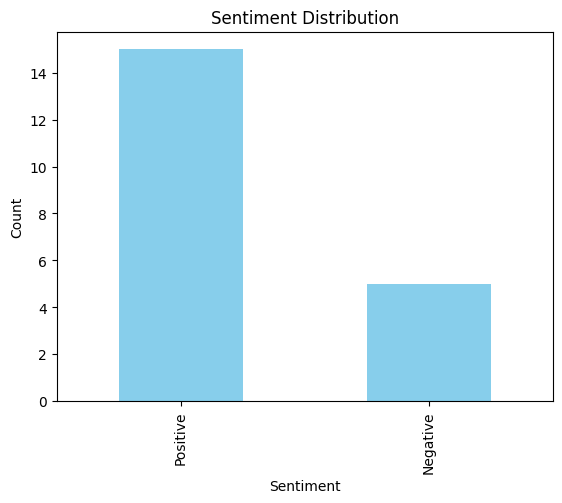

In [35]:
df_reviews['Sentiment_Label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


**Generate a Word Cloud of the Cleaned Reviews**


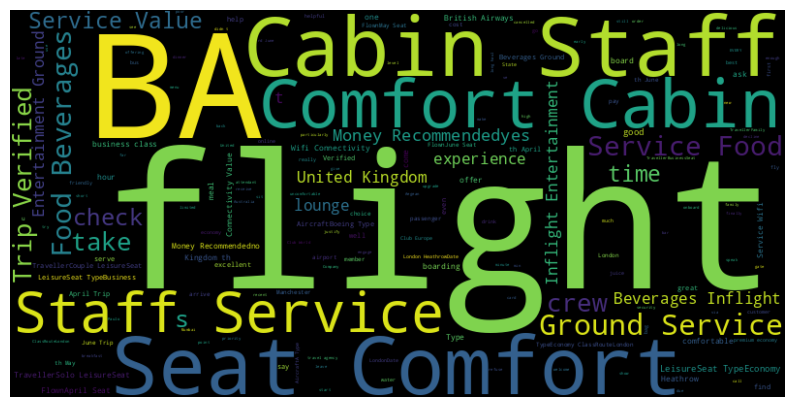

In [36]:
text = ' '.join(df_reviews['Lemmatized_Reviews'])
wordcloud = WordCloud(width=800, height=400).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Topic Modeling Using LDA

In [37]:
from gensim import corpora
from gensim.models import LdaModel


In [38]:
# Tokenize lemmatized reviews
df_reviews['Tokens'] = df_reviews['Lemmatized_Reviews'].apply(word_tokenize)

from gensim import corpora
from gensim.models import LdaModel


# Create a dictionary from the tokens
dictionary = corpora.Dictionary(df_reviews['Tokens'])

# Create a corpus (list of BoW vectors)
corpus = [dictionary.doc2bow(text) for text in df_reviews['Tokens']]


In [39]:
from gensim import corpora
# Tokenize the lemmatized reviews
df_reviews['Tokens'] = df_reviews['Lemmatized_Reviews'].apply(word_tokenize)

# Create dictionary and corpus
dictionary = corpora.Dictionary(df_reviews['Tokens'])
corpus = [dictionary.doc2bow(text) for text in df_reviews['Tokens']]

# Build LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15, random_state=42)

# Print topics
for idx, topic in lda_model.print_topics(num_words=5):
    print(f"Topic {idx+1}: {topic}")


Topic 1: 0.042*"to" + 0.025*"I" + 0.023*"be" + 0.019*"the" + 0.019*"and"
Topic 2: 0.046*"be" + 0.038*"the" + 0.025*"and" + 0.025*"to" + 0.013*"in"
Topic 3: 0.013*"Mumbai" + 0.012*"not" + 0.010*"in" + 0.009*"put" + 0.009*"be"
Topic 4: 0.010*"economy" + 0.010*"downgrade" + 0.007*"my" + 0.005*"book" + 0.005*"down"
Topic 5: 0.025*"the" + 0.023*"be" + 0.022*"to" + 0.017*"of" + 0.017*"and"


# PREDICTIVE ANALYSIS

get data

In [40]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [41]:
data= '/customer_booking.csv'


In [44]:
import chardet
import pandas as pd

# Step 1: Detect encoding
with open('/content/customer_booking.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
    encoding = result['encoding']
    print("Detected encoding:", encoding)

# Step 2: Read CSV using the detected encoding
df = pd.read_csv('/content/customer_booking.csv', encoding=encoding)

# Step 3: Preview the data
print(df.head())


Detected encoding: ISO-8859-1
   num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0

In [46]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


# Exploratory Data Analysis

In [47]:
#checking for datatypes

df.dtypes

,0
num_passengers,int64
sales_channel,object
trip_type,object
purchase_lead,int64
length_of_stay,int64
flight_hour,int64
flight_day,object
route,object
booking_origin,object
wants_extra_baggage,int64


In [48]:
df.shape

(50000, 14)

In [50]:
#null values

df.isnull().sum()

#there is no null values

,0
num_passengers,0
sales_channel,0
trip_type,0
purchase_lead,0
length_of_stay,0
flight_hour,0
flight_day,0
route,0
booking_origin,0
wants_extra_baggage,0


In [51]:
df.booking_complete.value_counts()

,count
booking_complete,
0,42522
1,7478


# Mutual Information

In [52]:
X= df.drop('booking_complete',axis=1)
y= df.booking_complete

#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [53]:
X.dtypes

,0
num_passengers,int64
sales_channel,int64
trip_type,int64
purchase_lead,int64
length_of_stay,int64
flight_hour,int64
flight_day,int64
route,int64
booking_origin,int64
wants_extra_baggage,int64


In [54]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores # show a few features with their MI scores

,MI Scores
route,0.053470
booking_origin,0.046410
flight_duration,0.016176
wants_extra_baggage,0.010617
length_of_stay,0.007330
wants_in_flight_meals,0.003268
wants_preferred_seat,0.002211
num_passengers,0.001859
purchase_lead,0.001769
sales_channel,0.001134


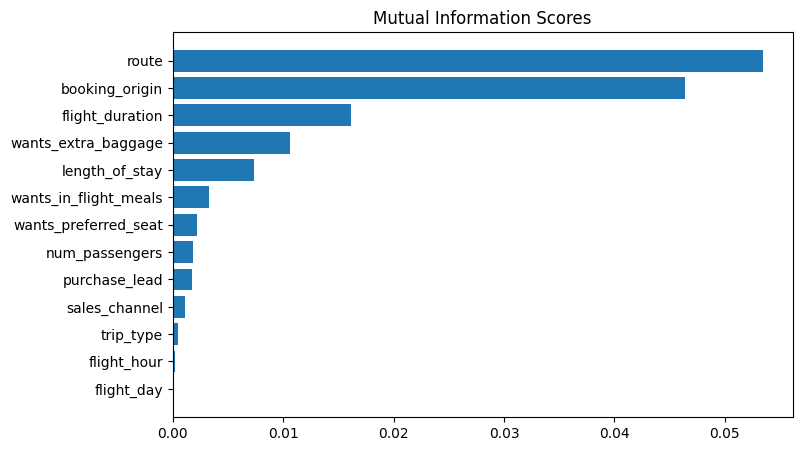

In [55]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

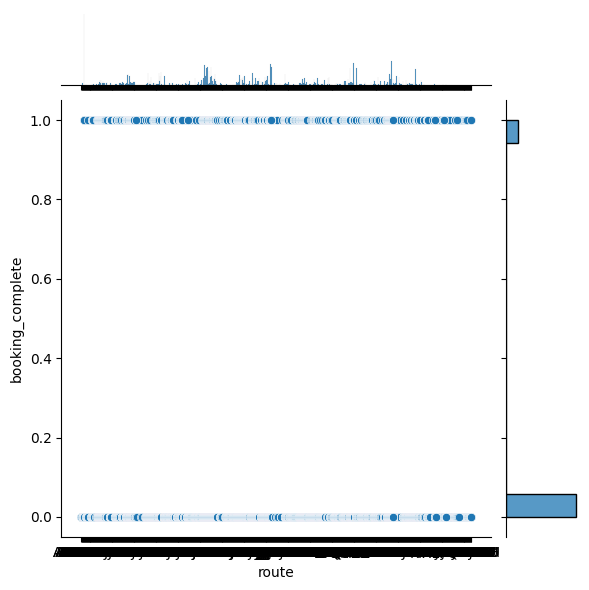

In [61]:
sns.jointplot(data=df, x='route', y='booking_complete', kind='scatter')


We can see

1.   route
2.   booking_origin
3.   flight_duration          
4.   wants_extra_baggage      
5.   length_of_stay          

 are the top 5 features which are dependant with booking_complete feature

In [62]:
#test train split

from sklearn.model_selection import train_test_split

# dataset split
# creating a function for dataset split
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y,test_size=0.2,random_state = 0)

# Use the same function above for the validation set
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25,random_state = 0)
    return (train_X, val_X, train_y, val_y)

In [65]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X

# Model 1 : Random forest classifier with top 6 features

In [66]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier



#assigning the features under a list

features=['route','booking_origin','flight_duration','wants_extra_baggage', 'length_of_stay','num_passengers']
X= df[features]
#one hot encoding
X = pd.get_dummies(X, columns=features)
X= scale(X)
y= df.booking_complete

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  83.36
AUC score:  0.5657818407546988


# Model 2 : Random forest classifier with all features

In [67]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  84.76
AUC score:  0.5479604084813514


# Model 3 : XGB classifier with top 6 features

In [68]:
from xgboost import XGBClassifier

X= df[features]

#one hot encoding
X = pd.get_dummies(X, columns=features)
X= scale(X)

y= df.booking_complete

X_train,X_val,y_train,y_val= dataset(X,y)
xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  84.72
AUC score:  0.5189398567740671


# Model 4 : XGB classifier with all features

In [69]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete

X_train,X_val,y_train,y_val= dataset(X,y)


xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  84.98
AUC score:  0.5424676175552812


Finalizing random forest model with all features as final model, as it has goos accuracy and higher auc score compared to other models

Validating with test data set

In [ ]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete

train_full_X,test_X, train_full_y, test_y = train_test_split(X, y,test_size=0.2,random_state = 0)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(train_full_X, train_full_y)
preds= forest_model.predict(test_X)

print('ACCURACY: ',accuracy_score(test_y,preds)*100)
print('AUC score: ',roc_auc_score(test_y,preds))